In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,-16.907658,level_194,level_21,level_61,level_80,level_139,level_70,level_48,level_27,level_199,...,level_61,level_45,level_66,level_444,level_299,level_438,level_314,level_442,level_25,level_79
1,13.173611,level_426,level_59,level_308,level_187,level_309,level_99,level_398,level_10,level_309,...,level_467,level_238,level_395,level_214,level_477,level_74,level_65,level_210,level_434,level_229
2,-24.634721,level_259,level_268,level_2,level_66,level_204,level_379,level_440,level_266,level_208,...,level_465,level_442,level_477,level_83,level_418,level_220,level_317,level_168,level_317,level_330
3,-28.889694,level_4,level_467,level_223,level_185,level_493,level_399,level_436,level_84,level_417,...,level_153,level_358,level_477,level_10,level_322,level_111,level_242,level_499,level_243,level_275
4,11.143388,level_29,level_433,level_89,level_292,level_78,level_119,level_225,level_57,level_119,...,level_170,level_354,level_16,level_366,level_341,level_95,level_366,level_49,level_470,level_117


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-1.613044,7.309693,-17.785767,1.969784,-17.954727,-0.422620,-10.214963,-16.316675,-12.062746,-6.635621,...,-2.450519,-5.307431,-16.498058,-7.187587,-15.078140,-15.450775,9.307387,-5.057685,-8.329166,-1.105957
1,-3.345912,-11.179383,-9.296097,-3.085181,-10.636432,-12.083500,-12.189272,-7.263878,7.885662,-5.065825,...,-11.529781,-6.832922,-14.899030,-1.822661,1.508089,-7.146757,-3.656139,-6.747974,-0.770327,-8.589438
2,1.096256,-12.897146,4.730032,-4.440202,-15.097173,-11.504246,-12.538091,-0.655624,-21.253826,-12.918054,...,0.232059,-4.846785,-14.899030,3.691378,-15.007704,1.709418,-18.292191,3.740072,-29.605933,-2.382473
3,-6.043885,4.087619,-1.826510,4.862241,13.001756,15.588116,13.205725,10.677192,-10.181010,-10.971738,...,1.686216,-2.996761,-6.827816,-7.590614,-5.550391,4.442275,-0.508748,7.296096,-1.374595,-1.105957
4,12.592230,9.351592,17.908038,2.314205,10.352554,0.822898,2.348441,1.894467,-8.158815,-2.434019,...,8.339193,4.765558,4.383108,9.772782,19.225731,9.142069,14.381890,6.567419,-8.329166,-0.249482


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-1.189601,3.239000,-10.838493,1.201294,-14.351030,-0.313430,-7.045294,-10.875722,-9.459114,-4.171693,...,-1.185211,-3.362592,-10.064938,-4.485625,-9.433327,-14.284450,0.536543,-4.064510,-3.767950,-0.714570
1,-2.172107,-9.030694,-6.358005,-1.574773,-8.357936,-7.614960,-7.959597,-5.498445,5.444707,-3.834936,...,-5.998020,-2.491869,-12.681084,-0.910839,0.772592,-4.308604,-2.195945,-0.729158,-0.189000,-3.163784
2,0.637642,-8.293719,3.224296,-3.297465,-8.163491,-8.223806,-9.096305,-0.386405,-16.039755,-5.783740,...,0.127999,-1.129770,-12.681084,1.998449,-2.655265,0.901850,-9.857703,1.967284,-29.360009,-1.416476
3,-3.274597,3.025480,-1.451880,2.872828,12.325686,13.472276,6.355680,8.019223,-6.558431,-7.378532,...,0.866719,-1.471892,-2.090957,-3.817411,-3.029714,3.699033,-0.417870,3.404639,-0.871065,-0.714570
4,7.388958,6.270885,13.937263,1.246526,7.238080,0.648207,2.019714,1.235937,-5.440480,-1.376015,...,1.938650,2.801780,2.569122,4.983974,16.701618,6.093368,6.671650,4.822364,-3.767950,-0.171341


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-2.429800,9.478144,-5.724042e+00,0.160907,-3.568846e+00,1.268282,-4.093980,-9.170642,-9.649399e+00,-4.061774,...,0.003507,-0.171469,-6.493029,-1.300497,-5.337944,-18.414072,0.000000,-1.903406,-0.492786,0.101069
1,0.201904,-5.770232,2.220446e-16,-1.191729,-8.419630e+00,-3.349275,-7.843296,-2.072195,8.781943e+00,-0.630140,...,-3.787456,-0.109888,-12.169186,0.135093,-0.780486,-0.642486,0.541746,0.000000,0.000000,-0.618028
2,3.934290,-5.949222,9.318881e+00,1.507254,-2.115167e+01,-6.269846,-7.639893,2.294588,-2.220446e-16,-2.332152,...,2.925051,2.883001,-12.169186,7.332923,-0.657793,-0.241049,-4.664650,7.967789,0.000000,1.698408
3,-2.719407,3.283230,-6.207167e+00,1.663967,-2.220446e-16,19.386210,2.871416,6.496570,-1.156488e+01,-9.495806,...,-0.316220,-7.198142,-3.723235,-9.582345,-9.724437,1.316487,-2.182906,2.569129,-2.448430,-2.279102
4,2.328340,2.969105,2.220446e-16,-0.305870,1.746467e+00,-0.847380,3.515272,0.791242,-7.039588e+00,-19.879679,...,0.000000,5.394772,2.565390,17.577781,0.000000,1.120931,4.030480,4.283975,-19.284753,-2.563977


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.504259,0.482239,0.154502,0.169229,False
1,var_1_impact_code,0.538102,0.518626,0.160459,0.162919,False
2,var_2_impact_code,0.518221,0.488762,0.153543,0.206053,False
3,var_3_impact_code,0.518402,0.488867,0.126099,0.203749,False
4,var_4_impact_code,0.526746,0.503099,0.159614,0.132191,False
5,var_5_impact_code,0.548220,0.519622,0.194347,0.198982,False
6,var_6_impact_code,0.541297,0.518205,0.174802,0.192643,False
7,var_7_impact_code,0.561650,0.539927,0.194140,0.199807,False
8,var_8_impact_code,0.514836,0.492104,0.151708,0.148226,False
9,var_9_impact_code,0.519385,0.489752,0.119879,0.181701,False


(0.8367044120276735, 5.232582447486599e-30)


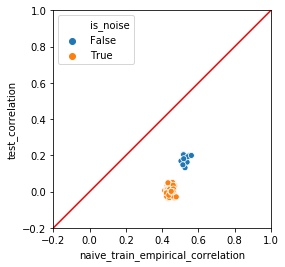

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8344368404075787, 1.0335060354554691e-29)


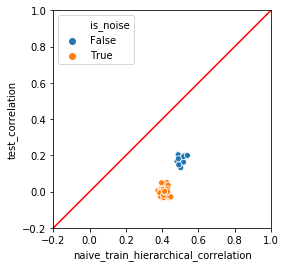

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8324368768399079, 1.8678518361774684e-29)


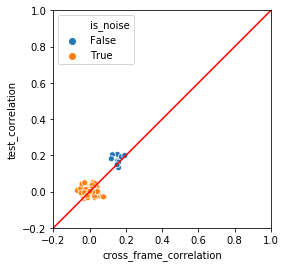

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
105,noise_95_impact_code,impact_code,True,True,0.014670,0.460701,110.0,False
106,noise_96_impact_code,impact_code,True,True,0.010972,0.581136,110.0,False
107,noise_97_impact_code,impact_code,True,True,0.042655,0.031887,110.0,False
108,noise_98_impact_code,impact_code,True,True,0.016810,0.397925,110.0,False
109,noise_99_impact_code,impact_code,True,True,0.002333,0.906629,110.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code',
 'noise_47_impact_code',
 'noise_93_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,13.173611,0.998098,-0.029227,1.462602,1.004548
1,11.143388,-2.017126,-1.096311,0.795206,0.655695
2,-11.141977,3.897548,3.258649,1.526012,1.452242
3,-12.880687,4.356965,1.616418,1.864823,3.279771
4,20.844042,10.905027,13.402822,4.405788,6.753046


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.2437430581263125


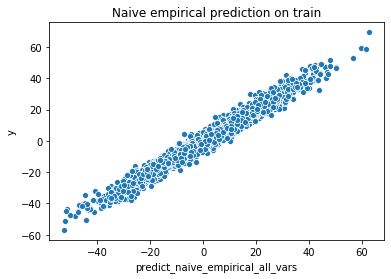

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.687901104748199


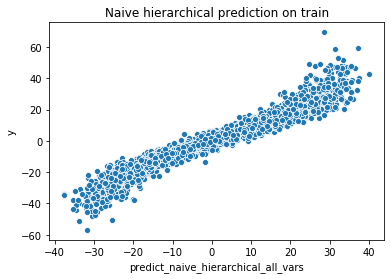

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

15.253371570178853


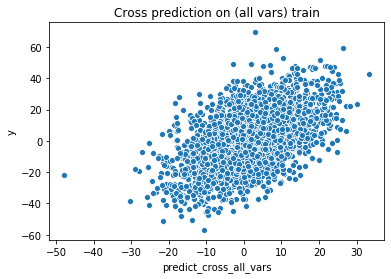

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

15.632679155163398


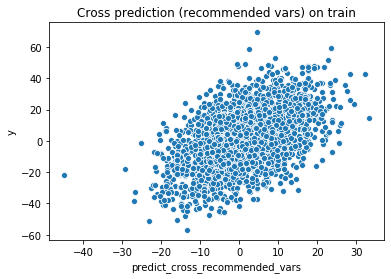

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.94717031406752


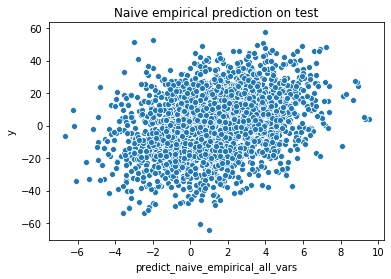

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

17.681689705718867


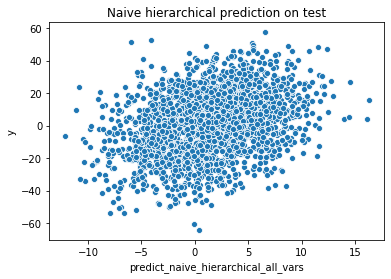

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

15.768320960731803


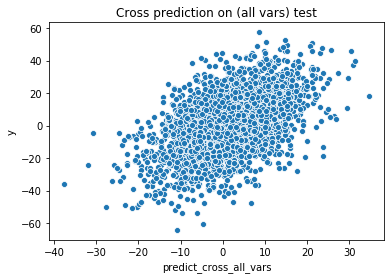

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.493141572688373


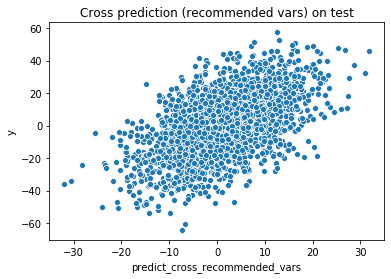

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     664.0
Date:                Fri, 26 Jul 2019   Prob (F-statistic):               0.00
Time:                        06:56:36   Log-Likelihood:                -6569.6
No. Observations:                2531   AIC:                         1.336e+04
Df Residuals:                    2420   BIC:                         1.401e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.3312      0.066     20.188      0.000       1.202       1.460
var_0_impact_code        0.0710      0.008      8.361      0.000       0.054       0.088
var_1_impact_code        0.0540      0.008      6.563      0.000       0.038       0.070
var_2_impact_code        0.0635      0.008      7.587      0.000       0.047       0.080
var_3_impact_code        0.0596      0.008      7.148      0.000       0.043       0.076
var_4_impact_code        0.0580      0.008      6.988      0.000       0.042       0.074
var_5_impact_code        0.0671      0.008      8.371      0.000       0.051       0.083
var_6_impact_code        0.0682      0.008      8.376      0.000       0.052       0.084
var_7_impact_code        0.0583      0.008      7.261      0.000       0.043       0.074
var_8_impact_code        0.0626      0.008      7.455      0.000       0.046       0.079
var_9_impact_code        0.0779      0.008      9.338      0.000       0.062       0.094
noise_0_impact_code      0.0354      0.009      3.800      0.000       0.017       0.054
noise_1_impact_code      0.0365      0.009      4.039      0.000       0.019       0.054
noise_2_impact_code      0.0408      0.009      4.369      0.000       0.022       0.059
noise_3_impact_code      0.0334      0.010      3.494      0.000       0.015       0.052
noise_4_impact_code      0.0456      0.010      4.744      0.000       0.027       0.064
noise_5_impact_code      0.0369      0.009      4.009      0.000       0.019       0.055
noise_6_impact_code      0.0458      0.010      4.808      0.000       0.027       0.065
noise_7_impact_code      0.0198      0.010      2.055      0.040       0.001       0.039
noise_8_impact_code      0.0381      0.009      4.126      0.000       0.020       0.056
noise_9_impact_code      0.0315      0.009      3.320      0.001       0.013       0.050
noise_10_impact_code     0.0322      0.009      3.432      0.001       0.014       0.051
noise_11_impact_code     0.0479      0.009      5.147      0.000       0.030       0.066
noise_12_impact_code     0.0376      0.010      3.841      0.000       0.018       0.057
noise_13_impact_code     0.0389      0.009      4.139      0.000       0.020       0.057
noise_14_impact_code     0.0423      0.009      4.517      0.000       0.024       0.061
noise_15_impact_code     0.0410      0.010      4.298      0.000       0.022       0.060
noise_16_impact_code     0.0316      0.010      3.290      0.001       0.013       0.050
noise_17_impact_code     0.0452      0.010      4.702      0.000       0.026       0.064
noise_18_impact_code     0.0347      0.009      3.770      0.000       0.017       0.053
noise_19_impact_code     0.0506      0.009      5.457      0.000       0.032       0.069
noise_20_impact_code     0.0544      0.009      6.012    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.9679285560701428

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.06528961393944832

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     9.022
Date:                Fri, 26 Jul 2019   Prob (F-statistic):          1.36e-114
Time:                        06:56:36   Log-Likelihood:                -10488.
No. Observations:                2531   AIC:                         2.120e+04
Df Residuals:                    2420   BIC:                         2.185e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.4072      0.316      4.459      0.000       0.788       2.026
var_0_impact_code        0.4141      0.049      8.369      0.000       0.317       0.511
var_1_impact_code        0.3821      0.045      8.436      0.000       0.293       0.471
var_2_impact_code        0.4082      0.046      8.794      0.000       0.317       0.499
var_3_impact_code        0.3654      0.049      7.493      0.000       0.270       0.461
var_4_impact_code        0.3920      0.048      8.170      0.000       0.298       0.486
var_5_impact_code        0.4784      0.044     10.816      0.000       0.392       0.565
var_6_impact_code        0.4373      0.045      9.675      0.000       0.349       0.526
var_7_impact_code        0.4361      0.044      9.986      0.000       0.350       0.522
var_8_impact_code        0.3955      0.048      8.230      0.000       0.301       0.490
var_9_impact_code        0.3835      0.048      8.022      0.000       0.290       0.477
noise_0_impact_code      0.0126      0.061      0.205      0.838      -0.108       0.133
noise_1_impact_code      0.0169      0.054      0.311      0.756      -0.090       0.124
noise_2_impact_code      0.0517      0.060      0.856      0.392      -0.067       0.170
noise_3_impact_code     -0.0431      0.058     -0.746      0.456      -0.156       0.070
noise_4_impact_code     -0.0668      0.059     -1.130      0.259      -0.183       0.049
noise_5_impact_code      0.0727      0.056      1.303      0.193      -0.037       0.182
noise_6_impact_code      0.0114      0.057      0.200      0.842      -0.100       0.123
noise_7_impact_code     -0.0737      0.062     -1.183      0.237      -0.196       0.048
noise_8_impact_code      0.1413      0.057      2.500      0.012       0.030       0.252
noise_9_impact_code     -0.0822      0.061     -1.348      0.178      -0.202       0.037
noise_10_impact_code    -0.0523      0.061     -0.861      0.390      -0.171       0.067
noise_11_impact_code    -0.0121      0.058     -0.210      0.834      -0.126       0.101
noise_12_impact_code    -0.2130      0.062     -3.422      0.001      -0.335      -0.091
noise_13_impact_code    -0.0388      0.058     -0.670      0.503      -0.152       0.075
noise_14_impact_code    -0.0503      0.059     -0.855      0.393      -0.166       0.065
noise_15_impact_code     0.0004      0.057      0.006      0.995      -0.112       0.113
noise_16_impact_code    -0.0348      0.060     -0.578      0.563      -0.153       0.083
noise_17_impact_code     0.0113      0.057      0.199      0.842      -0.100       0.123
noise_18_impact_code     0.1067      0.058      1.839      0.066      -0.007       0.221
noise_19_impact_code    -0.0402      0.056     -0.713      0.476      -0.151       0.070
noise_20_impact_code     0.0613      0.057      1.080    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.29081862513775736

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.278467325722243

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     71.86
Date:                Fri, 26 Jul 2019   Prob (F-statistic):          2.69e-151
Time:                        06:56:36   Log-Likelihood:                -10550.
No. Observations:                2531   AIC:                         2.113e+04
Df Residuals:                    2518   BIC:                         2.120e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.4013      0.312      4.494      0.000       0.790       2.013
var_0_impact_code        0.4064      0.049      8.328      0.000       0.311       0.502
var_1_impact_code        0.3970      0.045      8.918      0.000       0.310       0.484
var_2_impact_code        0.4142      0.046      9.048      0.000       0.324       0.504
var_3_impact_code        0.3878      0.048      8.035      0.000       0.293       0.482
var_4_impact_code        0.3827      0.047      8.140      0.000       0.290       0.475
var_5_impact_code        0.4875      0.044     11.186      0.000       0.402       0.573
var_6_impact_code        0.4440      0.045      9.953      0.000       0.357       0.531
var_7_impact_code        0.4238      0.043      9.896      0.000       0.340       0.508
var_8_impact_code        0.3859      0.047      8.130      0.000       0.293       0.479
var_9_impact_code        0.3795      0.047      8.102      0.000       0.288       0.471
noise_47_impact_code     0.1028      0.055      1.853      0.064      -0.006       0.212
noise_93_impact_code     0.1541      0.052      2.955      0.003       0.052       0.256
==============================================================================
Omnibus:                        4.497   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                4.364
Skew:                           0.074   Prob(JB):                        0.113
Kurtosis:                       2.860   Cond. No.                         7.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.25510947375181725

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.30343110262504314